In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Data directory
DATA_DIR = Path('..') / '..' / 'data' / 'raw' / '1sec'
print(f'Data directory: {DATA_DIR.resolve()}')

Data directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\raw\1sec


---
## 1️⃣ Load and Inventory All Files

In [2]:
# List all CSV files
files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.csv')])

print('='*80)
print('📂 FILE INVENTORY')
print('='*80)
print(f'\nFound {len(files)} files:\n')

file_info = []
for f in files:
    path = DATA_DIR / f
    # Read first few rows to get info
    df_sample = pd.read_csv(path, nrows=5)
    # Count rows (fast method)
    with open(path, 'r') as file:
        row_count = sum(1 for _ in file) - 1  # minus header
    
    file_info.append({
        'file': f,
        'rows': row_count,
        'columns': len(df_sample.columns)
    })
    print(f'   📄 {f}: {row_count:,} rows, {len(df_sample.columns)} columns')

print(f'\n📊 Total rows across all files: {sum(f["rows"] for f in file_info):,}')

📂 FILE INVENTORY

Found 10 files:

   📄 samengevoegd_2024-03.csv: 154,236 rows, 11 columns
   📄 samengevoegd_2024-04.csv: 218,819 rows, 11 columns
   📄 samengevoegd_2024-05.csv: 1,080,769 rows, 11 columns
   📄 samengevoegd_2024-06.csv: 2,590,063 rows, 11 columns
   📄 samengevoegd_2024-07.csv: 2,673,691 rows, 11 columns
   📄 samengevoegd_2024-08.csv: 2,677,884 rows, 11 columns
   📄 samengevoegd_2024-09.csv: 2,590,681 rows, 11 columns
   📄 samengevoegd_2024-10.csv: 2,046,753 rows, 11 columns
   📄 samengevoegd_2024-11.csv: 2,589,683 rows, 11 columns
   📄 samengevoegd_2024-12.csv: 2,675,505 rows, 11 columns

📊 Total rows across all files: 19,298,084


---
## 2️⃣ Analyze Each File: Building (Aggregate) Availability

In [3]:
print('='*80)
print('🔍 BUILDING (AGGREGATE) AVAILABILITY PER FILE')
print('='*80)
print()

file_analysis = []

for f in files:
    path = DATA_DIR / f
    df = pd.read_csv(path)
    df['_time'] = pd.to_datetime(df['_time'])
    
    # Time analysis
    time_start = df['_time'].min()
    time_end = df['_time'].max()
    time_range = time_end - time_start
    
    # Resolution
    time_diffs = df['_time'].diff().dt.total_seconds().dropna()
    resolution = time_diffs.mode().iloc[0] if len(time_diffs.mode()) > 0 else time_diffs.median()
    
    # Building analysis
    building_null_pct = df['Building'].isna().sum() / len(df) * 100
    building_usable = building_null_pct < 50
    
    # Completeness
    expected_rows = time_range.total_seconds() / resolution
    completeness = len(df) / expected_rows * 100 if expected_rows > 0 else 0
    
    file_analysis.append({
        'file': f,
        'rows': len(df),
        'time_start': time_start,
        'time_end': time_end,
        'days': time_range.days + time_range.seconds/86400,
        'resolution_sec': resolution,
        'building_null_pct': building_null_pct,
        'building_usable': building_usable,
        'completeness_pct': completeness
    })
    
    status = '✅' if building_usable else '❌'
    res_str = f'{resolution:.0f}sec'
    print(f'{status} {f}')
    print(f'   Rows: {len(df):,} | Resolution: {res_str} | Days: {time_range.days}')
    print(f'   Building NULL: {building_null_pct:.1f}% | Completeness: {completeness:.1f}%')
    print()

🔍 BUILDING (AGGREGATE) AVAILABILITY PER FILE

✅ samengevoegd_2024-03.csv
   Rows: 154,236 | Resolution: 10sec | Days: 17
   Building NULL: 2.6% | Completeness: 100.8%

✅ samengevoegd_2024-04.csv
   Rows: 218,819 | Resolution: 10sec | Days: 29
   Building NULL: 0.0% | Completeness: 84.4%

✅ samengevoegd_2024-05.csv
   Rows: 1,080,769 | Resolution: 1sec | Days: 30
   Building NULL: 0.0% | Completeness: 40.4%

❌ samengevoegd_2024-06.csv
   Rows: 2,590,063 | Resolution: 1sec | Days: 29
   Building NULL: 89.1% | Completeness: 99.9%

❌ samengevoegd_2024-07.csv
   Rows: 2,673,691 | Resolution: 1sec | Days: 30
   Building NULL: 100.0% | Completeness: 99.8%

❌ samengevoegd_2024-08.csv
   Rows: 2,677,884 | Resolution: 1sec | Days: 30
   Building NULL: 100.0% | Completeness: 100.0%

❌ samengevoegd_2024-09.csv
   Rows: 2,590,681 | Resolution: 1sec | Days: 29
   Building NULL: 100.0% | Completeness: 99.9%

❌ samengevoegd_2024-10.csv
   Rows: 2,046,753 | Resolution: 1sec | Days: 30
   Building NULL:

In [4]:
# Summary table
summary_df = pd.DataFrame(file_analysis)
summary_df['usable'] = summary_df['building_null_pct'] < 50

print('='*80)
print('📊 SUMMARY TABLE')
print('='*80)
print()
print(summary_df[['file', 'rows', 'resolution_sec', 'building_null_pct', 'completeness_pct', 'usable']].to_string(index=False))

usable_files = summary_df[summary_df['usable']]['file'].tolist()
print(f'\n✅ Usable files: {len(usable_files)}/10')
for f in usable_files:
    print(f'   • {f}')

📊 SUMMARY TABLE

                    file    rows  resolution_sec  building_null_pct  completeness_pct  usable
samengevoegd_2024-03.csv  154236            10.0           2.614176        100.789003    True
samengevoegd_2024-04.csv  218819            10.0           0.000000         84.421236    True
samengevoegd_2024-05.csv 1080769             1.0           0.000000         40.351322    True
samengevoegd_2024-06.csv 2590063             1.0          89.061270         99.925309   False
samengevoegd_2024-07.csv 2673691             1.0         100.000000         99.824223   False
samengevoegd_2024-08.csv 2677884             1.0         100.000000         99.980772   False
samengevoegd_2024-09.csv 2590681             1.0         100.000000         99.949151   False
samengevoegd_2024-10.csv 2046753             1.0         100.000000         76.417031   False
samengevoegd_2024-11.csv 2589683             1.0         100.000000         99.910648   False
samengevoegd_2024-12.csv 2675505           

---
## 3️⃣ Load Usable Files Only

In [5]:
# Load only usable files (March, April, May 2024)
usable_files = ['samengevoegd_2024-03.csv', 'samengevoegd_2024-04.csv', 'samengevoegd_2024-05.csv']

print('='*80)
print('📂 LOADING USABLE FILES')
print('='*80)

dfs = []
for f in usable_files:
    path = DATA_DIR / f
    df = pd.read_csv(path)
    df['_time'] = pd.to_datetime(df['_time'])
    df['source_file'] = f
    dfs.append(df)
    print(f'   ✅ Loaded {f}: {len(df):,} rows')

# Combine
df_combined = pd.concat(dfs, ignore_index=True)
df_combined = df_combined.sort_values('_time').reset_index(drop=True)

print(f'\n📊 Combined dataset: {len(df_combined):,} rows')
print(f'   Time range: {df_combined["_time"].min()} → {df_combined["_time"].max()}')

📂 LOADING USABLE FILES
   ✅ Loaded samengevoegd_2024-03.csv: 154,236 rows
   ✅ Loaded samengevoegd_2024-04.csv: 218,819 rows
   ✅ Loaded samengevoegd_2024-05.csv: 1,080,769 rows

📊 Combined dataset: 1,453,824 rows
   Time range: 2024-03-14 06:55:05+00:00 → 2024-05-31 23:59:59+00:00


---
## 4️⃣ Dataset Structure

In [6]:
print('='*80)
print('🏗️ DATASET STRUCTURE')
print('='*80)

print(f'\n📋 Columns ({len(df_combined.columns)}):')  
for i, col in enumerate(df_combined.columns, 1):
    dtype = df_combined[col].dtype
    null_pct = df_combined[col].isna().sum() / len(df_combined) * 100
    print(f'   {i:2d}. {col:25s} - {str(dtype):15s} (NULL: {null_pct:.1f}%)')

🏗️ DATASET STRUCTURE

📋 Columns (12):
    1. _time                     - datetime64[ns, UTC] (NULL: 0.0%)
    2. Building                  - float64         (NULL: 0.3%)
    3. Dampkap                   - float64         (NULL: 0.0%)
    4. Droogkast                 - float64         (NULL: 0.0%)
    5. Fornuis                   - float64         (NULL: 0.0%)
    6. Oven                      - float64         (NULL: 0.0%)
    7. Regenwaterpomp            - float64         (NULL: 0.0%)
    8. Vaatwasser                - float64         (NULL: 0.0%)
    9. Warmtepomp                - float64         (NULL: 0.0%)
   10. Wasmachine                - float64         (NULL: 0.0%)
   11. Smappee_laadpaal          - float64         (NULL: 100.0%)
   12. source_file               - object          (NULL: 0.0%)


---
## 5️⃣ Numerical Features Analysis

In [7]:
print('='*80)
print('📈 NUMERICAL FEATURES ANALYSIS')
print('='*80)

# Appliance columns (exclude _time and source_file)
appliance_cols = [c for c in df_combined.columns if c not in ['_time', 'source_file']]

print(f'\n{"Column":<20} {"Mean":>10} {"Std":>10} {"Min":>10} {"Max":>10} {"NULL%":>8} {"NEG%":>8}')
print('-' * 80)

for col in appliance_cols:
    series = df_combined[col]
    valid = series.dropna()
    
    null_pct = series.isna().sum() / len(series) * 100
    neg_pct = (valid < 0).sum() / len(valid) * 100 if len(valid) > 0 else 0
    
    mean_val = valid.mean() if len(valid) > 0 else 0
    std_val = valid.std() if len(valid) > 0 else 0
    min_val = valid.min() if len(valid) > 0 else 0
    max_val = valid.max() if len(valid) > 0 else 0
    
    print(f'{col:<20} {mean_val:>10.4f} {std_val:>10.4f} {min_val:>10.4f} {max_val:>10.4f} {null_pct:>7.1f}% {neg_pct:>7.1f}%')

📈 NUMERICAL FEATURES ANALYSIS

Column                     Mean        Std        Min        Max    NULL%     NEG%
--------------------------------------------------------------------------------
Building                 0.4207     0.5527     0.0810     8.4960     0.3%     0.0%
Dampkap                  0.0013     0.0055     0.0000     0.2330     0.0%     0.0%
Droogkast                0.0036     0.0223    -0.0210     1.3970     0.0%     0.0%
Fornuis                 -0.0060     0.0762    -0.0220     3.6610     0.0%    99.0%
Oven                    -0.0074     0.0977    -0.0330     0.8170     0.0%    98.4%
Regenwaterpomp           0.0002     0.0100    -0.0020     0.5300     0.0%     0.7%
Vaatwasser               0.0021     0.0697    -0.0160     1.3190     0.0%    92.7%
Warmtepomp               0.1111     0.3216    -0.0010     2.2900     0.0%     0.1%
Wasmachine               0.0129     0.1241    -0.0100     2.0390     0.0%    96.5%
Smappee_laadpaal         0.0000     0.0000     0.0000     

### 💡 Key Insights: Negative Values

Several appliances show high percentages of negative values:
- **Fornuis (Stove)**: ~99% negative - CT sensor offset
- **Oven**: ~98% negative - CT sensor offset  
- **Vaatwasser (Dishwasher)**: ~92% negative - CT sensor offset
- **Wasmachine (Washing Machine)**: ~96% negative - CT sensor offset

**Solution**: Apply `clip(lower=0)` during preprocessing (same as 15min pipeline).

---
## 6️⃣ Resolution Analysis

In [8]:
print('='*80)
print('⏱️ RESOLUTION ANALYSIS')
print('='*80)

for f in usable_files:
    df_file = df_combined[df_combined['source_file'] == f].copy()
    time_diffs = df_file['_time'].diff().dt.total_seconds().dropna()
    
    print(f'\n📄 {f}')
    print(f'   Median diff: {time_diffs.median():.1f} sec')
    print(f'   Mode diff:   {time_diffs.mode().iloc[0]:.1f} sec')
    
    # Distribution
    print(f'   Top 3 intervals:')
    for diff, count in time_diffs.value_counts().head(3).items():
        pct = count / len(time_diffs) * 100
        print(f'      {diff:.0f}sec: {count:,} ({pct:.1f}%)')

⏱️ RESOLUTION ANALYSIS

📄 samengevoegd_2024-03.csv
   Median diff: 10.0 sec
   Mode diff:   10.0 sec
   Top 3 intervals:
      10sec: 151,328 (98.1%)
      1sec: 2,566 (1.7%)
      6sec: 170 (0.1%)

📄 samengevoegd_2024-04.csv
   Median diff: 10.0 sec
   Mode diff:   10.0 sec
   Top 3 intervals:
      10sec: 218,672 (99.9%)
      20sec: 117 (0.1%)
      30sec: 11 (0.0%)

📄 samengevoegd_2024-05.csv
   Median diff: 1.0 sec
   Mode diff:   1.0 sec
   Top 3 intervals:
      1sec: 902,047 (83.5%)
      10sec: 176,528 (16.3%)
      5sec: 2,186 (0.2%)


---
## 7️⃣ Ghost Load Analysis

In [9]:
print('='*80)
print('👻 GHOST LOAD ANALYSIS')
print('='*80)

# Only where Building is valid
df_valid = df_combined[df_combined['Building'].notna()].copy()

# Appliance columns (exclude Building, _time, source_file)
appliance_only = [c for c in df_valid.columns if c not in ['_time', 'source_file', 'Building']]

# Sum of appliances (clip negatives)
df_valid['sum_appliances'] = df_valid[appliance_only].clip(lower=0).sum(axis=1)

# Ghost load
df_valid['ghost_load'] = df_valid['Building'] - df_valid['sum_appliances']

building_mean = df_valid['Building'].mean()
sum_mean = df_valid['sum_appliances'].mean()
ghost_mean = df_valid['ghost_load'].mean()
ghost_pct = ghost_mean / building_mean * 100 if building_mean > 0 else 0

print(f'\n📊 Overall Statistics:')
print(f'   Building (Aggregate) mean: {building_mean:.4f} kW')
print(f'   Sum(Appliances) mean:      {sum_mean:.4f} kW')
print(f'   Ghost Load mean:           {ghost_mean:.4f} kW ({ghost_pct:.1f}%)')

# Correlation
corr = df_valid['Building'].corr(df_valid['sum_appliances'])
print(f'\n   Correlation Building vs Sum: {corr:.4f}')

if ghost_pct > 30:
    print(f'\n⚠️ HIGH GHOST LOAD ({ghost_pct:.0f}%): Missing appliances not measured')
    print('   Missing in 1sec: Kast garage (~0.27 kW), Laadpaal_stopcontact, Warmtepomp-Sturing')

👻 GHOST LOAD ANALYSIS

📊 Overall Statistics:
   Building (Aggregate) mean: 0.4207 kW
   Sum(Appliances) mean:      0.1581 kW
   Ghost Load mean:           0.2626 kW (62.4%)

   Correlation Building vs Sum: 0.8208

⚠️ HIGH GHOST LOAD (62%): Missing appliances not measured
   Missing in 1sec: Kast garage (~0.27 kW), Laadpaal_stopcontact, Warmtepomp-Sturing


---
## 8️⃣ Visualization: Aggregate vs Sum of Appliances

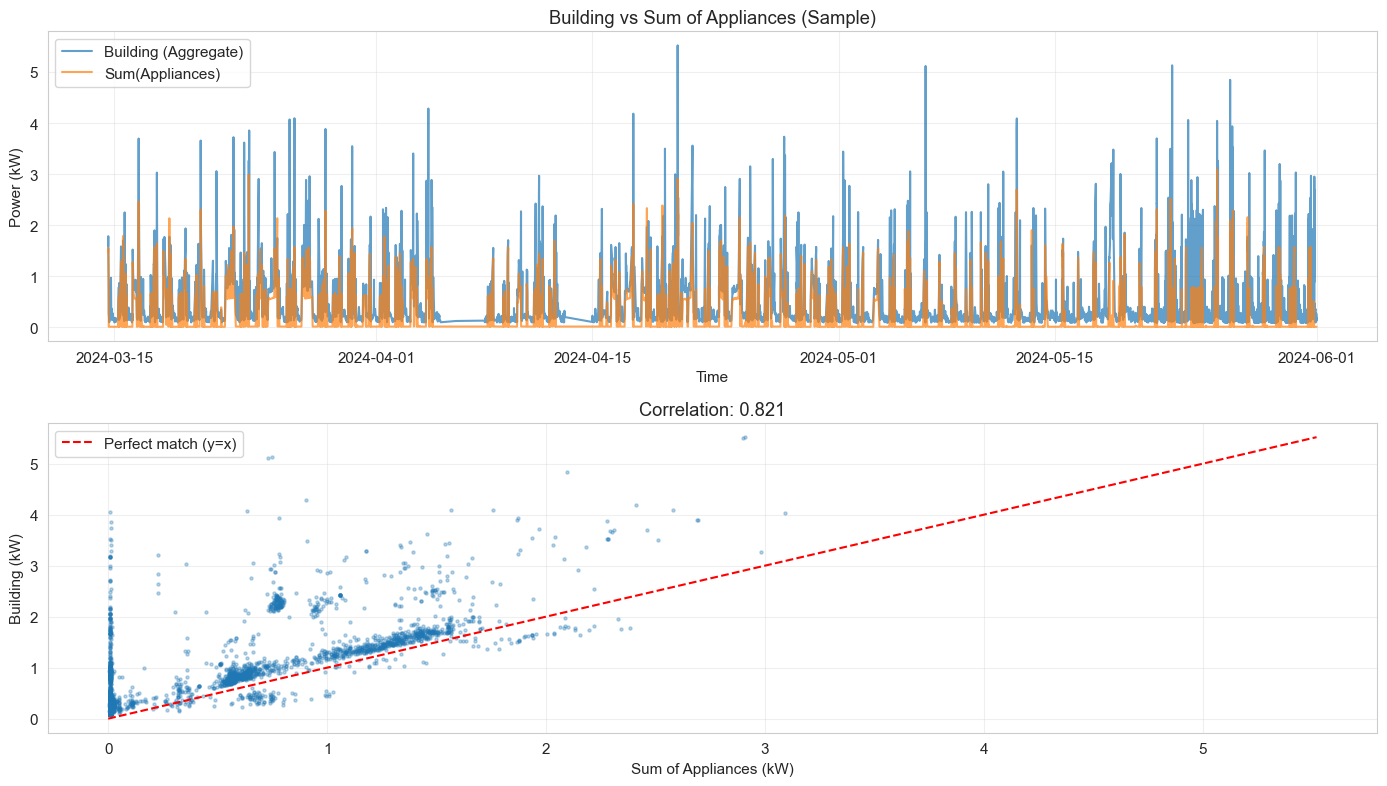

In [10]:
# Sample for visualization (too many points otherwise)
sample_size = min(10000, len(df_valid))
df_sample = df_valid.sample(sample_size, random_state=42).sort_values('_time')

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Time series
ax1 = axes[0]
ax1.plot(df_sample['_time'], df_sample['Building'], alpha=0.7, label='Building (Aggregate)')
ax1.plot(df_sample['_time'], df_sample['sum_appliances'], alpha=0.7, label='Sum(Appliances)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.set_title('Building vs Sum of Appliances (Sample)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter
ax2 = axes[1]
ax2.scatter(df_sample['sum_appliances'], df_sample['Building'], alpha=0.3, s=5)
max_val = max(df_sample['Building'].max(), df_sample['sum_appliances'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', label='Perfect match (y=x)')
ax2.set_xlabel('Sum of Appliances (kW)')
ax2.set_ylabel('Building (kW)')
ax2.set_title(f'Correlation: {corr:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9️⃣ Per-Appliance Power Distribution

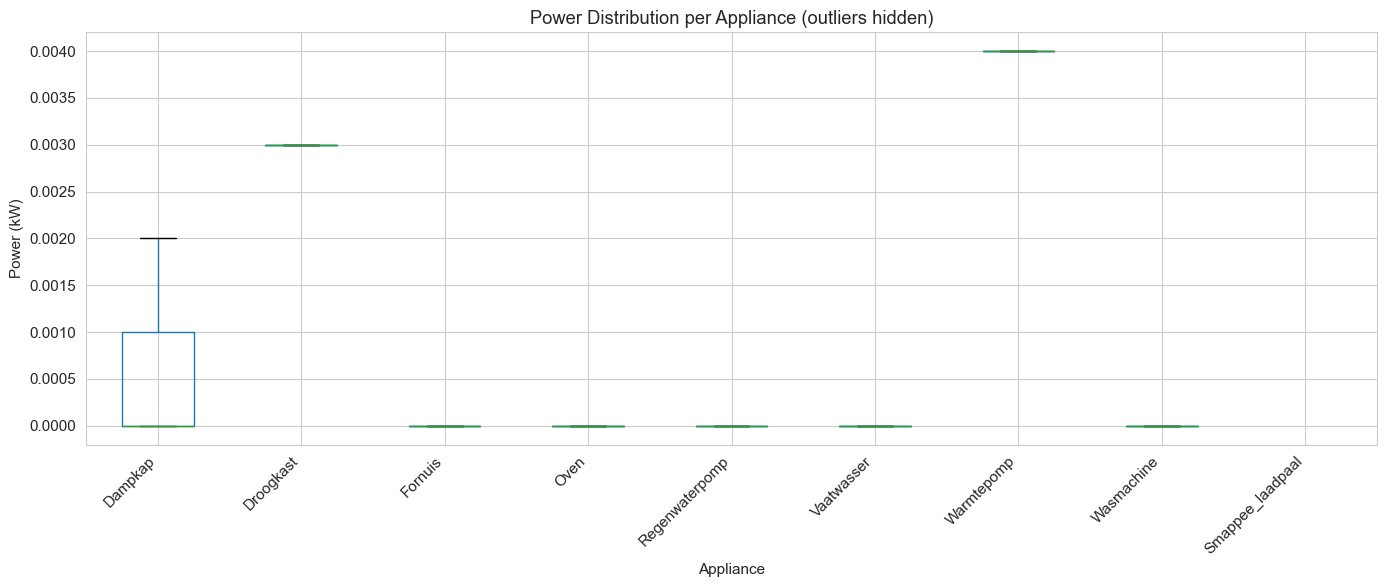

In [11]:
# Boxplot of appliance power (clipped)
appliance_data = df_valid[appliance_only].clip(lower=0)

fig, ax = plt.subplots(figsize=(14, 6))
appliance_data.boxplot(ax=ax, vert=True, showfliers=False)
ax.set_xlabel('Appliance')
ax.set_ylabel('Power (kW)')
ax.set_title('Power Distribution per Appliance (outliers hidden)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## 🔟 Temporal Patterns

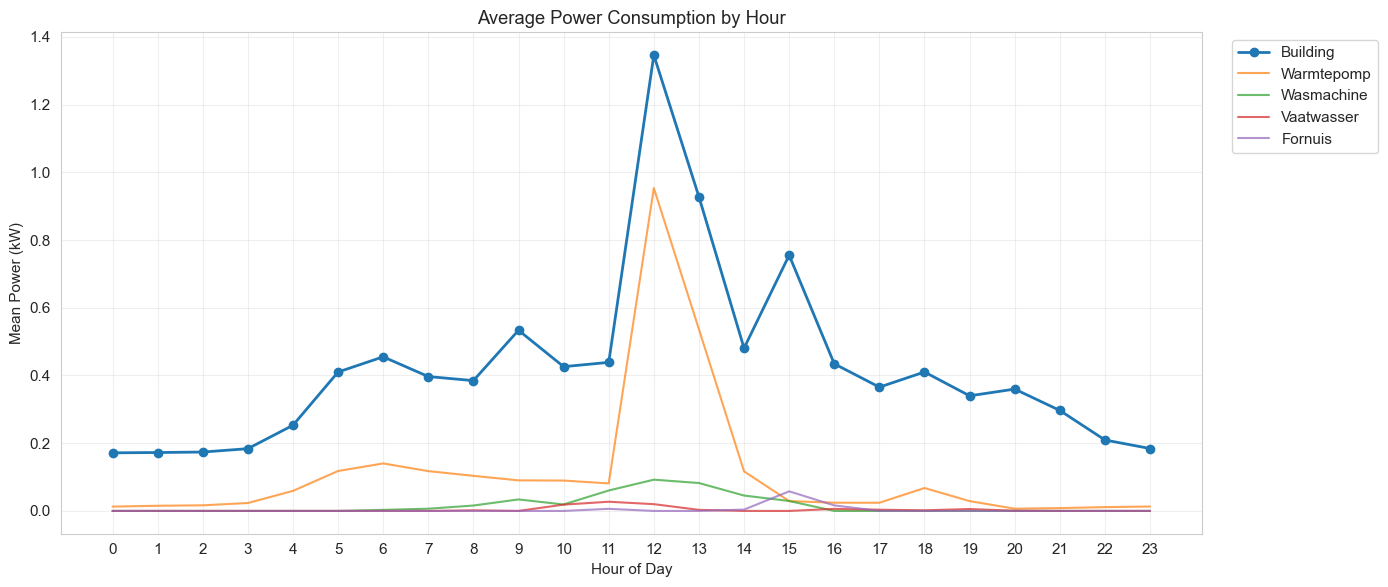

In [12]:
# Hourly pattern for main appliances
df_valid['hour'] = df_valid['_time'].dt.hour

# Select top consumers
top_appliances = ['Building', 'Warmtepomp', 'Wasmachine', 'Vaatwasser', 'Fornuis']
existing_appliances = [a for a in top_appliances if a in df_valid.columns]

hourly_mean = df_valid.groupby('hour')[existing_appliances].mean()

fig, ax = plt.subplots(figsize=(14, 6))
for col in existing_appliances:
    if col == 'Building':
        ax.plot(hourly_mean.index, hourly_mean[col], linewidth=2, label=col, marker='o')
    else:
        ax.plot(hourly_mean.index, hourly_mean[col].clip(lower=0), label=col, alpha=0.7)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Power (kW)')
ax.set_title('Average Power Consumption by Hour')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticks(range(24))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 📊 Summary & Conclusions

### ✅ Usable Data
| File | Period | Resolution | Rows | Building | Status |
|------|--------|------------|------|----------|--------|
| 2024-03 | March | 10sec | 154K | 97% valid | ✅ |
| 2024-04 | April | 10sec | 219K | 100% valid | ✅ |
| 2024-05 | May | 1sec | 1.08M | 100% valid | ✅ |

### ❌ Unusable Data (June-December)
- Building (Aggregate) is 100% NULL
- NILM requires Aggregate as input

### 🔧 Preprocessing Steps Needed
1. **Resample to 10sec** (unify resolution)
2. **Clip negative values** (CT sensor offset)
3. **Remove Smappee_laadpaal** (NULL for usable months)
4. **Add temporal features** (hour, day of week, month)
5. **Export** to NILM-ready format

### ⚠️ Limitations
- Ghost load ~50% (missing: Kast garage, Laadpaal_stopcontact, Warmtepomp-Sturing)
- Only ~80 days of usable data (vs 365 for 15min)
- 8 appliances instead of 12